# Building the SFINCS model

Before running this notebook, first hydromt-sfincs needs to be installed. For this the steps as found in [0] can be followed.
Secondly, a data catalog of all necessary information should be prepared following [3]. For this case this can be found in the hel_data_catalog file.

After these prerequisites, the steps in [1] are followed in this notebook to build the model from script.


[0] https://deltares.github.io/hydromt_sfincs/latest/getting_started/installation
[1] https://deltares.github.io/hydromt_sfincs/latest/_examples/build_from_script.html
[2] https://deltares.github.io/hydromt_sfincs/latest/_examples/example_datasources.html
[3] https://deltares.github.io/hydromt/latest/_examples/prep_data_catalog.html

## 0. load necessary modules and set working directory

In [2]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils
from hydromt.log import setuplog

logger = setuplog("prepare data catalog", log_level=10)

k=%pwd
root = os.path.join(k, "xan_catalog\\helensville_data")


2023-06-20 10:41:15,767 - prepare data catalog - log - INFO - HydroMT version: 0.7.1


## 1. Add libraries
The first step is to load in the data catalog that was built in the hel_data_catalog.ipynb file. This data catalog houses all data necessary for the model.
There are some prespecified data catalogs available, more info on this can be found here: https://deltares.github.io/hydromt/latest/user_guide/data_existing_cat.html

In [3]:
# we overwrite (mode='w+') the existing model in the root directory if it exists

data_lib_list = os.listdir('xan_catalog/catalog')
list = []
for data in data_lib_list:
    list.append(os.path.join(k,'xan_catalog\catalog', data))

sf = SfincsModel(data_libs=list, root=root, mode="w+")


Model dir already exists and files might be overwritten: C:\Users\xfsmi\PycharmProjects\pythonProject\SFINCS\xan_catalog\helensville_data\gis.


## 2. Schematization
### 2.1 Set up grid
After the libraries have been added, the grid can be set up. Info on the way this is schematized can be found below
https://sfincs.readthedocs.io/en/latest/input.html#grid-characteristics

In [4]:
sf.setup_grid(
    x0=292000,
    y0=5930000,
    dx=50.0,
    dy=50.0,
    nmax=400,
    mmax=800,
    rotation=120,
    epsg=32560,             #Use EPSG 32560, because New Zealand falls in UTM zone 60S
)
## uncomment to plot basemap with grid
# _ = sf.plot_basemap(plot_region=True, bmap ="sat", zoomlevel=11)

### 2.2 Set up elevation
Next the topobathy for the region is set up. This is a combination of the DEM and a bathymetric dataset, the second of which fills in the first in the case there is a nodata value, or when the first data set falls below zmin =0.01.

When working with a larger dataset, it could be helpful to only load them in for the grid defined in the last step. This is further explained in https://deltares.github.io/hydromt_sfincs/latest/_examples/example_datasources.html

In [5]:
# In this example we want to combine 2 elevation datasets, elevtn as elevation and bathymetry as bathymetry, in that order.

# NOTE: from the 1st dataset (elevtn) only elevation above ("zmin":0.001) meters is used;
# the 2nd elevation dataset (bathymetry) is used where the 1st dataset returned nodata values


datasets_dep = [{"da": 'elevtn', "zmin": 0.01},{"da": 'bathymetry'}]
# Add depth information to modelgrid based on these chosen datasets
dep = sf.setup_dep(datasets_dep=datasets_dep)

# # Make a plot of the merged topobathy, here colour limits are set between an elevation of -5 to 5 meters
# _ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

### 2.3 Set mask of grid
In this step for which cells in the domain the calculations will be done for is set up via a mask

In [6]:
# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation of -3 meters
sf.setup_mask_active(zmin=-3, reset_mask=True)

## Make a plot of the mask file
# _ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

### 2.4 outflow boundaries and water level cells
Next the outflow boundaries and water level cells are added for the model domain

In [7]:
# Loading a shapefile clicked by user:
# file_name = "xan_catalog/helensville_data/outflow_boundaries/outflow_boundaries.geojson"
# gdf_include = sf.data_catalog.get_geodataframe(file_name)


In [8]:
# Here we add water level cells along the coastal boundary, for cells up to an elevation of -2 meters
sf.setup_mask_bounds(btype="waterlevel", zmax=-2, reset_bounds=True)
# Here we add outflow cells, only where clicked in shapefile along part of the lateral boundaries
# sf.setup_mask_bounds(btype="outflow", include_mask=gdf_include, reset_bounds=True)

# Make a plot of the mask file
# fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
# gdf_include.to_crs(sf.crs).boundary.plot(ax=ax, color="k", lw=1, ls="--") # plot the shapefile given by the user as dashed line


### 2.5 Add differing roughnesses
To accomplish this, first a shapefile with the rivers is loaded in and added into the manning roughness file. This is to ensure the correct roughness for these rivers. After this, the file is combined with land use data, to fill in the roughnesses for all places where there are no rivers

In [13]:
# --> this is used in making subgrid tables

# to ensure a correct lower roughness of the rivers in the domain, we 'burn in' the river with a lower manning roughness value.
# the position of the river is based on global data, that is loaded below

# read river shapefile and add manning value to the attributes
gdf = sf.data_catalog.get_rasterdataset("rivers_lin", geom=sf.region).to_crs(
    sf.crs
)
gdf["geometry"] = gdf.buffer(50)    # can be increased to increase width of riverlines
gdf["manning"] = 0.03

## rasterize the manning value of gdf to the  model grid
da_manning = sf.grid.raster.rasterize(gdf, "manning", nodata=np.nan)

# # uncomment to plot either the raster or the vector data:
# da_manning.plot(vmin=0, x='xc', y='yc', cmap='viridis')
# gdf.plot()

In [15]:
## use the river manning raster in combination with vito land to derive the manning roughness file
## NOTE that we can combine in-memory data with data from the data catalog
datasets_rgh = [{"manning": da_manning}, {"lulc": "vito"}]

sf.setup_manning_roughness(
    datasets_rgh=datasets_rgh,
    manning_land=0.04,
    manning_sea=0.02,
    rgh_lev_land=0,  # the minimum elevation of the land
)
## uncomment to see plot of manning roughness for model domain
# _ = sf.plot_basemap(variable="manning", plot_bounds=False, bmap="sat", zoomlevel=12)

## 3. Subgrid calculations
Turning on subgrid calculations makes the model quicker to run, but is optional. I haven't used it yet since it gives less post-processing options

In [16]:
# # Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default is 20, nr_subgrid_pixels = 20).
# # For every subgrid pixel the topobathy data is loaded, ideally this consists also of high-resolution DEM datasets that you specify as user.
#
# sf.setup_subgrid(
#     datasets_dep=datasets_dep,
#     datasets_rgh=datasets_rgh,
#     nr_subgrid_pixels=5,
#     write_dep_tif=True,
#     write_man_tif=False,
# )
#
# # NOTE: we turned on that the merged topobathy of the different (high-res) datasets is written to a geotiff
#
# # NOTE: if you have a very large domain with 100,000s to millions of cells, and very high-resolution datasets (e.g. 1 m), this step might take minutes to hours!!!
# #       But good news; when finished succesfully, you can very quickly run very accurate SFINCS simulations!
# #       The whole point of the subgrid functionality of SFINCS is that by derived subgrid tables based on high res elevation data,
# #       you either have more accurate results or run on a coarser grid resolution (= much faster) or both


In [17]:
# # uncomment to see the subgrid table variables
# # sf.subgrid
#
# # we can plot the 2D subgrid variables
# _ = sf.plot_basemap(
#     variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
# )

## 4. Spatially varying infiltration
Read in a global dataset for the differing infiltration

In [18]:
# independent from subgrid files
# curve number infiltration based on global CN dataset
sf.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

# check all variables in the sf.grid dataset
sf.grid.data_vars.keys()


KeysView(Data variables:
    dep      (y, x) float32 69.08 74.7 79.34 80.69 ... 83.18 85.03 90.54 93.74
    msk      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    manning  (y, x) float64 0.104 0.1 0.1 0.1 ... 0.08169 0.08223 0.05587 0.034
    scs      (y, x) float64 dask.array<chunksize=(400, 800), meta=np.ndarray>)

# 5. Forcing

### 5.1 water level time-series as forcing
First the model simulation time is set. Afterwards, the x and y locations for the input water level data are added. This is stored in a .bnd file, and has to be in the same UTM reference system as the grid. Lastly the water levels for these locations are added, which is stored in sf.forcing as 'bzs'

In [19]:
# Change period of model simulation time, specified in yyyymmdd HHMMSS --> simulation time here is 24 hours
sf.setup_config(
    **{
        "tref": "20220601 000000",
        "tstart": "20220605 000000",
        "tstop": "20220606 000000",
    }
)


In [20]:
# Here we specify at what x&y-locations we have measured/modelled input water level data in the bndfile of SFINCS:

# x&y-locations in same coordinate reference system as the grid:
# The points below are, in order, Pouto Point and Kaipara River entrance
x = [247340.69059097898, 271376.3683612116]
y = [5971919.559736017, 5941162.19166127]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

# show what has been created:
display(bnd)

,geometry
1,POINT (247340.691 5971919.560)
2,POINT (271376.368 5941162.192)


In [21]:
# Here we specify at what times we are providing water level input, and afterwards what the values are per input location:

# In this case we will provide 3 values (periods=3) between the start (tstart=20220605 000000) and the end (tstop=20220606 000000) of the simulation:
time = pd.date_range(
    start=utils.parse_datetime(sf.config["tstart"]),
    end=utils.parse_datetime(sf.config["tstop"]),
    periods=3,
)

# and the actual water levels, in this case for input location 1 a water level rising from 0 to 2 meters and back to 0:
bzs = [[0, -1], [2.5, 3.9], [0, -0.5]]

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
display(bzspd)

,1,2
2022-06-05 00:00:00,0.0,-1.0
2022-06-05 12:00:00,2.5,3.9
2022-06-06 00:00:00,0.0,-0.5


In [22]:
# Actually add it to the SFINCS model class:
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)

# NOTE: the waterlevel forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()


dict_keys(['bzs'])

### 5.2 Precipitation forcing
The precipitation forcing can be either uniform or distributed. For now I have historical data for total precipitation in the area

In [23]:
# hourly rainfall rates of ECMWF' ERA5 data for the specific area and period have been made available for this period in the artefact data
sf.setup_precip_forcing_from_grid(precip="era5", aggregate=False)

# NOTE: the precipitation forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()

dict_keys(['bzs', 'precip'])

### 5.3 Check forcing
Below the two different forcing methods can be plotted to check if they appear logical

In [24]:
## Plot combined forcing time-series:
# _ = sf.plot_forcing()


## 6. Observation points
Optional. Observation points can be added to the grid to see the development of water level throughout the simulation time at these points. This creates the .his file for the postprocessing.
I tried everything I could think of (below)to get the observation points to have a crs, but errors keep happening so leave out for now.
- crs=4326 (like obs points in example)
- crs = 32560 (so same as grid)
- add one point at a time
- manually add crs to both observation points and .his file
- change .geojson to .shp or even manually add points

In [26]:
# Loading a point shapefile clicked by user:
# NOTE: merge=True makes HydroMT merge the new observation points with already existing observation points (if present)

#sf.setup_observation_points(locations=os.path.join(root, 'obs_points\obs_v3.geojson'), merge=True, crs=4326)
# NOTE: the observation points are now stored in the sf.geoms dictionary
# sf.geoms.keys()


## 7. Show model and write
The final step of the model build is to show the model in a plot and write the necessary files to be able to run the model

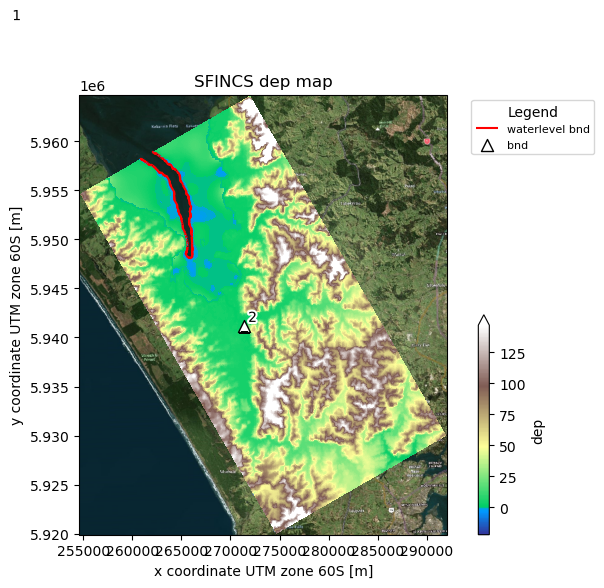

In [27]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png" ,bmap="sat", zoomlevel=12)


In [28]:
sf.write()  # write all
# Show created files in folder:
dir_list = os.listdir(sf.root)
print(dir_list)

['elevtn4326.tif', 'figs', 'GCN250_ARCII', 'gis', 'global_land_cover', 'gswo', 'hydromt.log', 'merit_hydro', 'nzbathy_2016', 'obs_points', 'precip.nc', 'rainfall_era5', 'rivers_shapefile', 'run.bat', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.dep', 'sfincs.ind', 'sfincs.inp', 'sfincs.man', 'sfincs.msk', 'sfincs.obs', 'sfincs.scs', 'sfincs_his.nc', 'sfincs_log.txt', 'sfincs_map.nc']


In [29]:
sf.config

{'mmax': 800,
 'nmax': 400,
 'dx': 50.0,
 'dy': 50.0,
 'x0': 292000,
 'y0': 5930000,
 'rotation': 120,
 'latitude': 0.0,
 'tref': '20220601 000000',
 'tstart': '20220605 000000',
 'tstop': '20220606 000000',
 'tspinup': 60.0,
 'dtout': 3600.0,
 'dthisout': 600.0,
 'dtrstout': 0.0,
 'dtmaxout': 99999.0,
 'trstout': -999.0,
 'dtwnd': 1800.0,
 'alpha': 0.5,
 'theta': 1.0,
 'huthresh': 0.01,
 'manning': 0.04,
 'zsini': 0.0,
 'rhoa': 1.25,
 'rhow': 1024.0,
 'dtmax': 60.0,
 'advection': 2,
 'baro': 0,
 'pavbnd': 0,
 'gapres': 101200.0,
 'stopdepth': 100.0,
 'crsgeo': 0,
 'btfilter': 60.0,
 'viscosity': 1,
 'inputformat': 'bin',
 'outputformat': 'net',
 'cdnrb': 3,
 'cdwnd': [0.0, 28.0, 50.0],
 'cdval': [0.001, 0.0025, 0.0015],
 'epsg': 32560,
 'depfile': 'sfincs.dep',
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind',
 'manningfile': 'sfincs.man',
 'scsfile': 'sfincs.scs',
 'bzsfile': 'sfincs.bzs',
 'bndfile': 'sfincs.bnd',
 'netamprfile': 'precip.nc'}